In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.integrate import odeint
from tqdm import tqdm
from sympy import Matrix

## Часть 1. Аппроксимация суммы эллипсов (по Минковскому):

In [2]:
def ellipse(q, Q):
    n = 100
    if np.all(Q != Q.T):
        raise ValueError('Q must be symmetric')
    phi = np.linspace(0, 2*np.pi, n)
    l = np.array([np.sin(phi), np.cos(phi)]).T
    res = np.array([q + Q@l_i / np.sqrt(np.dot(l_i, Q@l_i)) for l_i in l])
    return res[:, 0], res[:, 1]

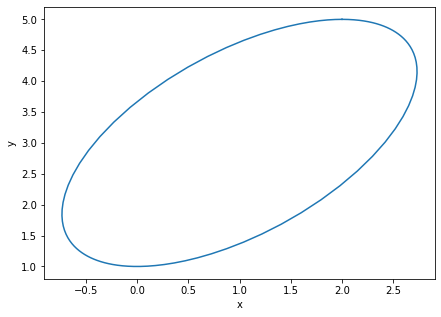

In [3]:
q = np.array([1, 3])
Q = np.array([[3, 2],[2, 4]])

plt.figure(figsize=(7, 5))
x, y = ellipse(q, Q)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
def sum_ellipse(*args):
    n = len(args)
    if n%2 != 0:
        raise ValueError('Number of arguments must be even')
    res_x = []
    res_y = []
    for i in range(n//2):
        q = args[2*i]
        Q = args[2*i+1]
        x, y = ellipse(q, Q)
        if len(res_x) == 0:
            res_x = x
            res_y = y
        else:
            res_x += x
            res_y += y
    return res_x, res_y

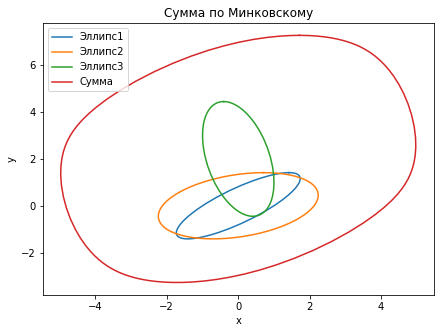

In [267]:
q1 = np.array([0, 0])
q2 = np.array([0, 0])
Q1 = np.array([[3, 2],[2, 2]])
Q2 = np.array([[5, 1], [1, 2]])
q3 = np.array([0, 2])
Q3 = np.array([[1, -1], [-1, 6]])

plt.figure(figsize=(7, 5))
x, y = ellipse(q1, Q1)
plt.plot(x, y, label='Эллипс1')

x, y = ellipse(q2, Q2)
plt.plot(x, y, label='Эллипс2')

x, y = ellipse(q3, Q3)
plt.plot(x, y, label='Эллипс3')

x, y = sum_ellipse(q1, Q1, q2, Q2, q3, Q3)
plt.plot(x, y, label='Сумма')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сумма по Минковскому')
plt.show()

In [261]:
def external_approximation(l, *args):
    n_ellipse = len(args)//2
    q0 = np.zeros(2)
    dot0 = 0
    Q0 = np.zeros((2, 2))
    for i in range(n_ellipse):
        q = args[2*i]
        Q = args[2*i+1]
        q0 += q
        dot0 += np.dot(l, Q@l)
        Q0 += Q / np.dot(l, Q@l)
    Q0 *= dot0
    return ellipse(q0, Q0)

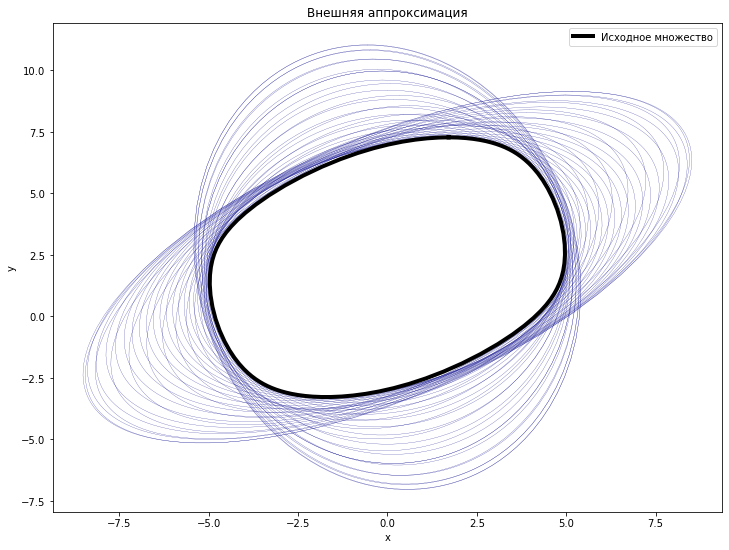

In [268]:
q1 = np.array([0, 0])
q2 = np.array([0, 0])
Q1 = np.array([[3, 2],[2, 2]])
Q2 = np.array([[5, 1], [1, 2]])
q3 = np.array([0, 2])
Q3 = np.array([[1, -1], [-1, 6]])
plt.figure(figsize=(12, 9))
phi = np.linspace(0, 2*np.pi, 50)
l = np.array([np.cos(phi), np.sin(phi)]).T
for i in range(len(l)):
    x, y = external_approximation(l[i], q1, Q1, q2, Q2, q3, Q3)
    plt.plot(x, y, color='darkblue', linewidth=0.2)
    
x, y = sum_ellipse(q1, Q1, q2, Q2, q3, Q3)
plt.plot(x, y, color='black', linewidth=4, label='Исходное множество')
plt.legend()
plt.title('Внешняя аппроксимация')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [275]:
def inner_approximation(l, *args):
    n_ellipse = len(args)//2
    q = args[0]
    Q = args[1]
    divide_by = np.sqrt(np.dot(l, Q@l))
    multiply_by = fractional_matrix_power(Q, 0.5)@l
    
    q0 = q
    Q0 = fractional_matrix_power(Q, 0.5)
    for i in list(range(n_ellipse))[1:]:
        q = args[2*i]
        Q = args[2*i+1]
        sqrt_Q = fractional_matrix_power(Q, 0.5)
        lam = np.sqrt(np.dot(l, Q@l)) / divide_by
        a = sqrt_Q@l
        b = lam * multiply_by
        V_a, d_a, u_a = np.linalg.svd(a.reshape(-1, 1))
        V_b, d_b, u_b = np.linalg.svd(b.reshape(-1, 1))
        S = u_a[0]*u_b[0] * (V_a@V_b.T)
        q0 += q
        Q0 += S@sqrt_Q
    Q0 = Q0.T @ Q0
    return ellipse(q0, Q0)

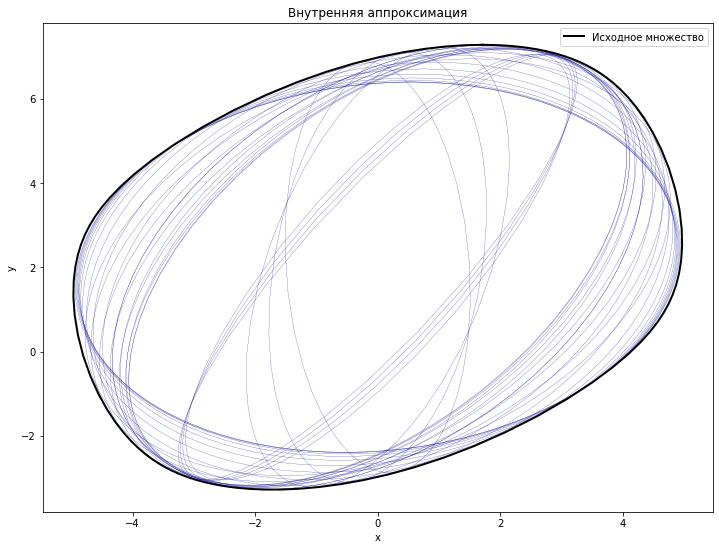

In [278]:
q1 = np.array([0, 0])
q2 = np.array([0, 0])
Q1 = np.array([[3, 2],[2, 2]])
Q2 = np.array([[5, 1], [1, 2]])
q3 = np.array([0, 2])
Q3 = np.array([[1, -1], [-1, 6]])
plt.figure(figsize=(12, 9))
phi = np.linspace(0, 2*np.pi, 30)
l = np.array([np.cos(phi), np.sin(phi)]).T
for i in range(len(l)):
    q1 = np.array([0, 0])
    x, y = inner_approximation(l[i], q1, Q1, q2, Q2, q3, Q3)
    plt.plot(x, y, color='darkblue', linewidth=0.2)
    
q1 = np.array([0, 0])
x, y = sum_ellipse(q1, Q1, q2, Q2, q3, Q3)
plt.plot(x, y, color='black', linewidth=2, label='Исходное множество')
plt.legend()
plt.title('Внутренняя аппроксимация')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Часть 2. Аппроксимация множества разрешимости:

$$W(t, t_1, \varepsilon(m, M)) = X(t, t_1)\varepsilon(m, M) - \int\limits_{t}^{t_1}X(t, \tau)B(\tau)\varepsilon(p(\tau), P(\tau))\,d\tau = \varepsilon(X(t, t_1)m, X(t, t_1)MX^*(t, t_1)) - \int\limits_{t}^{t_1}\varepsilon(X(t, \tau)B(\tau)p(\tau), X(t, \tau)B(\tau)P(\tau)B^*(\tau)X^*(t, \tau))\,d\tau = \varepsilon(X(t, t_1)m, X(t, t_1)MX^*(t, t_1)) + \int\limits_{t_1}^{t}\varepsilon(X(t, \tau)p_B(\tau), X(t, \tau)P_B(\tau)X^*(t, \tau))\,d\tau$$


$X(t, \tau)$ ищем из:
$\begin{equation*}
 \begin{cases}
   \displaystyle\frac{\partial X(t, \tau)}{\partial \tau} = -A(t)X(t, \tau), 
   \\
   X(\tau, \tau) = I.
 \end{cases}
\end{equation*}
$

### Регуляризация матрицы B:

In [32]:
B = np.array([[1, 0, 1], [2, 3, 1], [2, 0, 2]])
np.linalg.det(B)

0.0

In [28]:
def zero_B(B, B_eps=0.01):
    B = Matrix(B)
    V, J = B.jordan_form()
    V = np.array(V).astype('float')
    J = np.array(J).astype('float')
    cond = np.abs(np.diag(J)) < B_eps
    J += np.diag(cond*B_eps)
    return V @ J @ np.linalg.inv(V)

In [31]:
np.linalg.det(zero_B(B))

0.09000000000000026

In [ ]:
def find_X(A, tau_range):
    n = A(0).shape[0]
    ode_func = lambda y, t: -A(t)@y
    res = np.zeros((tau_range.size, n, n))
    for i in np.arange(0, n):
        y0 = np.eye(n)[i]
        res[:, i, :] = np.flip(odeint(ode_func, y0, np.flip(tau_range)), axis = 0)
    return res

In [3]:
def external_approximation(l, t, t1, A, B, Q, q, X1, x1, n_tau):
    tau_list = np.linspace(t, t1, n_tau)
    X = find_X(A, tau_list)
    p0 = np.dot(l, X[-1] @ X1 @ X[-1].T @ l)**(0.5)
    p = []
    Q_int = []
    q_int = []
    for i, tau in enumerate(tau_list):
        X_B = X[i] @ B(tau)
        p.append(np.dot(l, X_B @ Q(tau) @ X_B.T @ l)**(0.5))
        Q_int.append(X_B @ Q(tau) @ X_B.T / p[-1])
        q_int.append(X_B @ q(tau))
    p = np.array(p)
    Q_int = np.array(Q_int)
    q_int = np.array(q_int)
    R = (p0 + np.trapz(p, tau_list))*(X[-1] @ X1 @ X[-1].T / p0 + np.trapz(Q_int, tau_list, axis = 0))
    r = X[-1] @ x1 + np.trapz(q_int, tau_list, axis = 0)
    return r, R

In [4]:
def inner_approximation(l, t, t1, A, B, Q, q, X1, x1, n_tau):
    tau_list = np.linspace(t, t1, n_tau)
    X = find_X(A, tau_list)
    Q_int = []
    q_int = []
    sqrtX1 = fractional_matrix_power(X1, 0.5)
    for i, tau in enumerate(tau_list):
        X_B = X[i] @ B(tau)
        q_int.append(X_B @ q(tau))
        sqrtQ = fractional_matrix_power(Q(tau), 0.5)
        lam = np.linalg.norm(sqrtQ @ X_B.T @ l) /\
        np.linalg.norm(sqrtX1 @ X[-1].T @ l)
        a = sqrtQ @ X_B.T @ l
        b = lam * sqrtX1 * X[-1].T @ l
        V_a, d_a, u_a = np.linalg.svd(a.reshape(-1, 1))
        V_b, d_b, u_b = np.linalg.svd(b.reshape(-1, 1))
        S = u_a[0]*u_b[0]*(V_a@V_b.T)
        Q_int.append(S @ sqrtQ @ X_B.T)
    q_int = np.array(q_int)
    Q_int = np.array(Q_int)
    Q1 = sqrtX1 @ X[-1].T + np.trapz(Q_int, tau_list, axis = 0)
    R = Q1.T @ Q1
    r = X[-1] @ x1 + np.trapz(q_int, tau_list, axis = 0)
    return r, R

In [5]:
# Возвращает опорный вектор по направлению l эллипсоида с матрицей конфигурации Q и центром q 
def get_sup(q, Q, l):
    return q + Q @ l / np.sqrt(np.dot(l, Q @ l))

In [7]:
A = lambda t: np.array([[np.cos(t), -np.sin(t), 0], [np.sin(t), np.cos(t), 0], [0, 1, 0]])
B = lambda t: np.array([[np.cos(t), -np.sin(t), 0], [np.sin(t), np.cos(t), 0], [0, 1, 0]])
Q = lambda t: np.array([[np.abs(np.cos(t)) + 1, 0, 0], [0, np.abs(np.sin(t))+1, 0], [0, 0, 1]])
q = lambda t: np.array([t, 0, 0])
x1 = np.array([2, 1, 1])
X1 = np.array([[6, 1, 5], [1, 1, 2], [5, 2, 13]])

dim = 3
t1 = 10
n_tau = 1000
n_appr = 25

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [11:13<00:00,  1.35s/it]


Text(0.5, 0, 'x2')

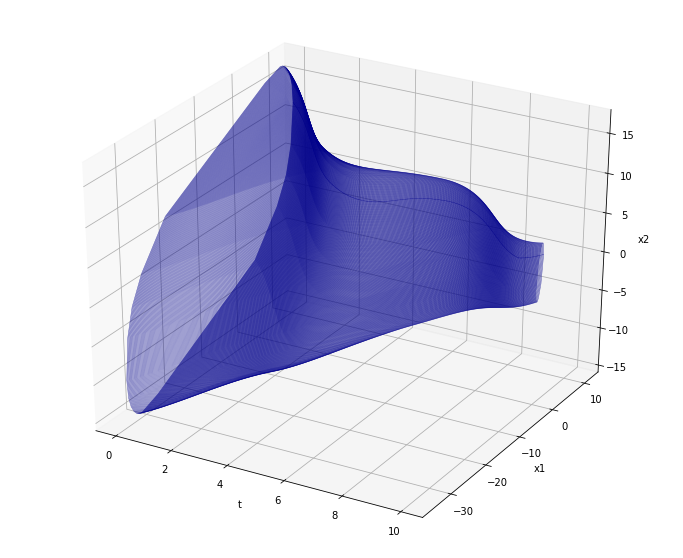

In [246]:
t_list = np.linspace(0, 10, 500)
phi = np.linspace(0, 2 * np.pi, n_appr)
basises = np.eye(dim)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for cur_t in tqdm(t_list):
    x = cur_t*np.ones(n_appr)
    appr = np.zeros((2, n_appr))
    for i in range(n_appr):
        l = basises[1] * np.cos(phi[i]) + basises[2] * np.sin(phi[i])
        r, R = external_approximation(l, cur_t, t1, A, B, Q, q, X1, x1, n_tau)
        appr[:, i] = get_sup(r, R, l)[np.array([1, 2])]
    y = appr[0, :]
    z = appr[1, :]
    ax.plot(x, y, z, alpha = 0.7, linewidth = 0.5, color='darkblue')
ax.set_xlabel('t')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [20]:
n = 20
cur_t = 10
phi_list = np.linspace(0, 2 * np.pi, 2 * n)
psi_list = np.linspace(-np.pi / 2, np.pi / 2, n)
x = np.zeros((2 * n, n))
y = np.zeros((2 * n, n))
z = np.zeros((2 * n, n))
basises =  np.eye(3)
for i, phi in enumerate(phi_list):
    for j, psi in enumerate(psi_list):
        l = np.cos(phi) * np.cos(psi) * basises[0] + \
                        np.sin(phi) * np.cos(psi) * basises[1] + np.sin(psi) * basises[2]
        r, R = external_approximation(l, cur_t, t1, A, B, Q, q, X1, x1, n_tau)
        [x[i, j], y[i, j], z[i, j]] = get_sup(r, R, l)[np.array([0, 1, 2])]

Text(0.5, 0, 'x3')

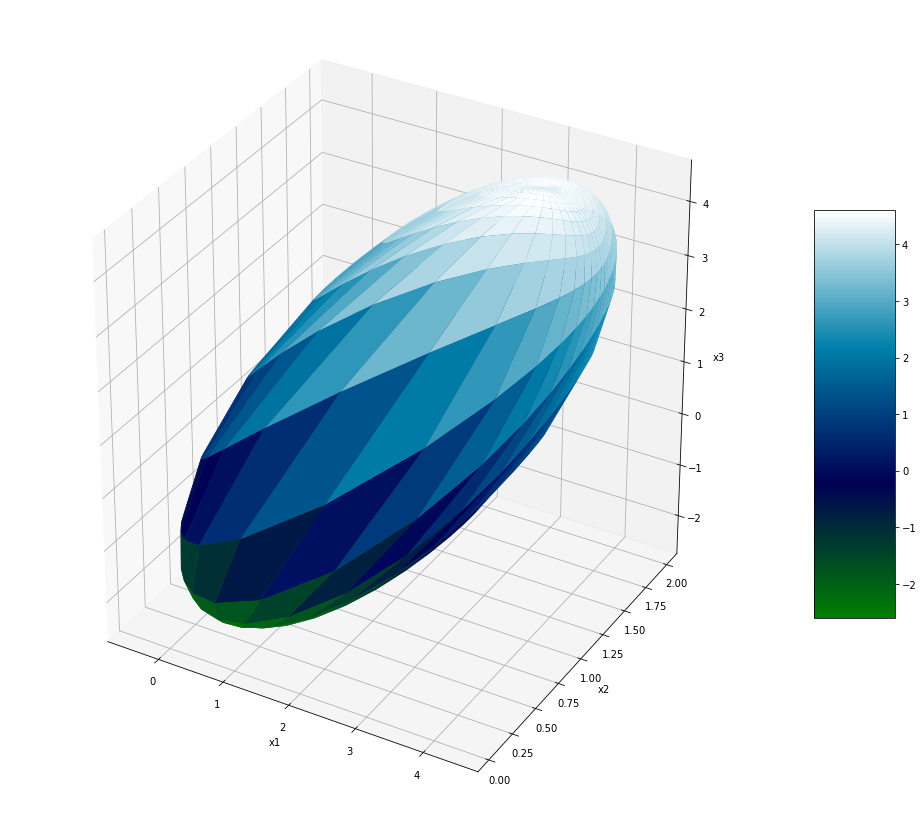

In [21]:
#cur_t = 10
fig = plt.figure(figsize=(17, 15))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='ocean')
fig.colorbar(surf, shrink=0.5, aspect=5, cmap='ocean')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')